# minerva

> Implementation of traditional associative memory models from Cognitive Science in the vein of *Minerva2*.

In this module we will be implementing $\mathsf{Minerva}$ models, which are a class of associative
memory models with deep theoretical connections to Hopfield networks. What distinguishes
them is that they are developed expicitly for the cognitive science context as a model of human
memory. Unifying all of these models is the tensor-based framework proposed in [Kelly, *et al.* (2017)](https://www.sciencedirect.com/science/article/pii/S0022249616301122).

In [ ]:
# | default_exp minerva

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | hide
# | export
import equinox as eqx
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
from beartype import beartype as typechecker
from einops import rearrange
from fastcore.basics import *
from fastcore.meta import *
from jaxtyping import Array, Float, jaxtyped

In [ ]:
# | hide
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Minerva2

Similar to Hopfield networks, the original $\mathsf{Minerva}$ model proposed by [Hintzman (1984)](https://link.springer.com/article/10.3758/BF03202365), MINERVA2, uses integer values. The main difference is that we allow for $0$ values
(denoting absent "features").
The recall function for MINERVA2 is given by:
$$
\mathcal{M}_\mathsf{Minerva2}(\sigma) = \sum^N_{i=1} \xi^i \left[ \frac{1}{D} \left( \sum^D_{j=1} \xi^i_j \sigma_j \right)^3 \right]
$$

In [ ]:
# | export
@jaxtyped(typechecker=typechecker)
class Minerva2(eqx.Module):
    Xi: Float[Array, "K D"]  # The stored memory traces.
    polynomial: int = 3  # The exponent to use on the similarity scores.

    def sims(
        self,
        query_state: Float[Array, " D"],  # The query "probe"
    ) -> Float[Array, " D"]:
        """Compute the similarities between a query probe and the stored memory traces."""
        return self.Xi @ query_state

    @eqx.filter_jit
    def recall(
        self,
        query_state: Float[Array, " D"],  # The query "probe"
    ) -> Float[Array, " D"]:
        """Simulate recall of a query by reconstructing it as a linear
        combination of the stored patterns.
        """
        D = query_state.shape[-1]
        sims = self.sims(query_state)
        sims = rearrange(sims, "d -> d 1")
        sims = sims**self.polynomial
        result = jnp.sum(sims * self.Xi, axis=0)
        result /= D 
        return result


In [ ]:
show_doc(Minerva2.sims)

---

### Minerva2.sims

>      Minerva2.sims (query_state:jaxtyping.Float[Array,'D'])

*Compute the similarities between a query probe and the stored memory traces.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| query_state | Float[Array, 'D'] | The query "probe" |
| **Returns** | **Float[Array, 'D']** |  |

In [ ]:
show_doc(Minerva2.recall)

---

### Minerva2.recall

>      Minerva2.recall (query_state:jaxtyping.Float[Array,'D'])

*Simulate recall of a query by reconstructing it as a linear
combination of the stored patterns.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| query_state | Float[Array, 'D'] | The query "probe" |
| **Returns** | **Float[Array, 'D']** |  |

MINERVA2 has a deep relationship with Hopfield networks, as they are formulated
from the energy-based AM perspective. Implicitly operating here is an energy function
defined as the anti-derivative of `Minerva2.recall`. 

In [ ]:
#|export
@patch
def energy(
    self: Minerva2, 
    query: Float[Array, " D"] # The query "probe"
):
    """Compute the energy of `query`."""
    return -jnp.sum((1 / (self.polynomial)) * (self.Xi @ query) ** (self.polynomial))

In [ ]:
show_doc(Minerva2.energy)

---

### Minerva2.energy

>      Minerva2.energy (query:jaxtyping.Float[Array,'D'])

*Compute the energy of `query`.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| query | Float[Array, 'D'] | The query "probe" |

In [ ]:
DATA_DIR = "../data/mnist"

pxw, pxh = 28, 28


def transform(data):
    data = np.array(data, dtype=jnp.float64)
    data = rearrange(data, "w h -> (w h)")
    data[data > 0.0] = 1.0
    data[data == 0.0] = -1.0
    return data


mnist_train = MNIST(DATA_DIR, train=True, transform=transform)
mnist_data_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_it = iter(mnist_data_loader)
mnist_data, _ = next(mnist_it)

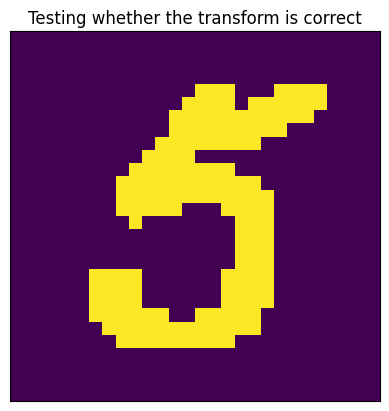

In [ ]:
def show_im(im: Float[Array, " WH"], title: str = "") -> None:
    im = rearrange(im, "(w h) -> w h", w=pxw, h=pxh)
    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])


show_im(mnist_data[1], title="Testing whether the transform is correct")

ERROR:2025-09-09 15:32:44,038:jax._src.xla_bridge:487: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/pop-harrier/Documents/Cogsci/MemoryModelAlmanac/.venv/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 485, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/pop-harrier/Documents/Cogsci/MemoryModelAlmanac/.venv/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pop-harrier/Documents/Cogsci/MemoryModelAlmanac/.venv/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_UNKNOWN


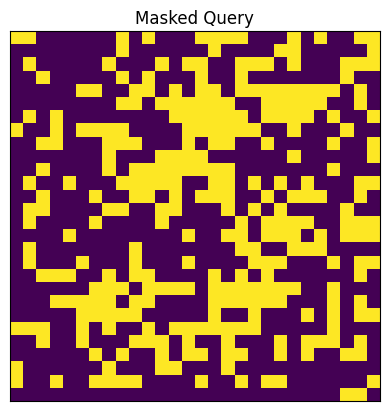

In [ ]:
def mask(
    state: Float[Array, " D"], pct_mask: float = 0.3, key: jax.Array = jr.PRNGKey(0)
) -> Float[Array, " D"]:
    prange = np.array([pct_mask, 1-pct_mask])
    return state * jr.choice(key, np.array([-1, 1]), p=prange, shape=state.shape)


Xi = jnp.array(mnist_data[:7])
min2 = Minerva2(Xi, polynomial=3)
query = Xi[1]
masked_query = mask(query)
show_im(masked_query, "Masked Query")

For our first test, we will simply show that it *can* recall:

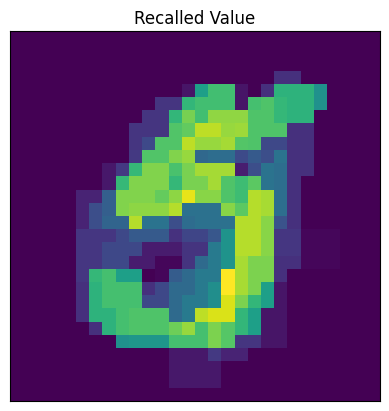

In [ ]:
recalled_value = min2.recall(masked_query)
show_im(recalled_value, "Recalled Value")

Intuitively we can see that the value $4$ is *preferred* as the most similar value. However, we also another
interesting property of MINERVA2 compared to Hopfield networks. Rather than asynchronously updating
random bits in the query state, we rather form recalled values as weighted sums of the stored traces,
where the weight is the correlation between the query provided and the patterns.

We can also compare the energy of the initial state and the final state:

In [ ]:
initial_energy = min2.energy(masked_query)
initial_energy

Array(-1.8811876e+07, dtype=float32)

In [ ]:
final_energy = min2.energy(recalled_value)
final_energy

Array(-1.2777563e+23, dtype=float32)

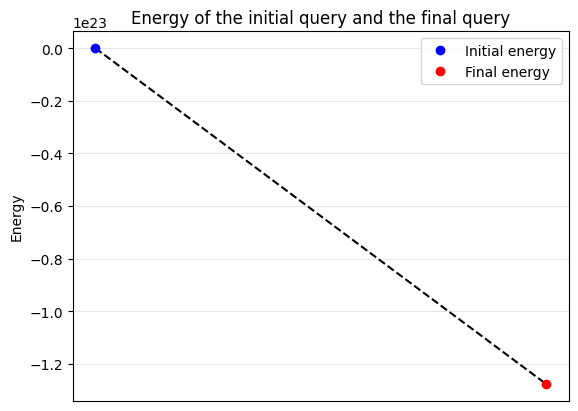

In [ ]:
initial_energy = min2.energy(masked_query)
final_energy = min2.energy(recalled_value)
energies = [initial_energy, final_energy]
plt.plot(energies, color="black", linestyle="--")
plt.xticks([])
plt.ylabel("Energy")
plt.title("Energy of the initial query and the final query")
plt.plot(0, initial_energy, "bo", label="Initial energy")
plt.plot(1, final_energy, "ro", label="Final energy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Another interesting thing about Minerva2 recall is that while it is normalized by the dimensionality of the stored
patterns $D$, we can normalize it by more familiar methods. For example, if we instead normalize recalled patterns
using $\text{sgn}$, we get near-perfect recall (and near identical performance to DAM models withs single-shot recall).

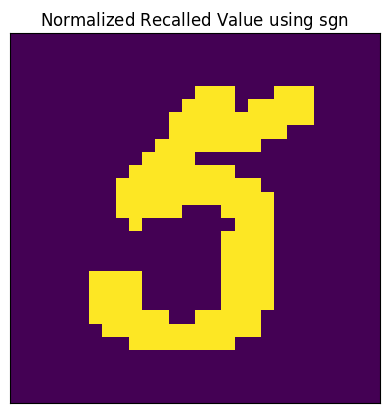

In [ ]:
normalized_recalled_value = jnp.sign(recalled_value)
show_im(normalized_recalled_value, r"Normalized Recalled Value using $\text{sgn}$")

### Iterative Recall

We can think of the single-shot recall performed by Minerva2 as a "collapsed" asynchronous recall which is performed over the indices
$i = 1, \dots, D$, where $D$ is the dimensionality of the pattern vectors. Hintzman, however, notes that we might also want to perform
iterated recall similar to the element-wise asynchronous recall of Hopfield networks, except updating each $i$ every single
time. Whenever we do not normalize the recalled value with $\text{sgn}$, we do not get very meaningful results:

In [ ]:
#|export
@patch
def iterative_recall(
    self: Minerva2,
    query: Float[Array, " D"],  # The query "probe"
    nsteps: int = 200,  # How many iterations you want to perform
    normalize_with_sgn: bool = False, # Whether or not to normalize the recalled value with `jnp.sign`.
) -> None:
    """Iteratively perform recall on a query state."""
    D = query.shape[-1]

    def update_step(query, _i):
        updated_query_state = self.recall(query)
        if normalize_with_sgn:
            updated_query_state = jnp.sign(updated_query_state)
        updated_energy = self.energy(updated_query_state)
        return (updated_query_state, (updated_query_state, updated_energy))

    final_query_state, (frames, energies) = lax.scan(
        update_step, query, np.arange(nsteps)
    )
    return final_query_state, (frames, energies)


In [ ]:
show_doc(Minerva2.iterative_recall)

---

### Minerva2.iterative_recall

>      Minerva2.iterative_recall (query:jaxtyping.Float[Array,'D'],
>                                 nsteps:int=200, normalize_with_sgn:bool=False)

*Iteratively perform recall on a query state.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| query | Float[Array, 'D'] |  | The query "probe" |
| nsteps | int | 200 | How many iterations you want to perform |
| normalize_with_sgn | bool | False | Whether or not to normalize the recalled value with `jnp.sign`. |
| **Returns** | **None** |  |  |

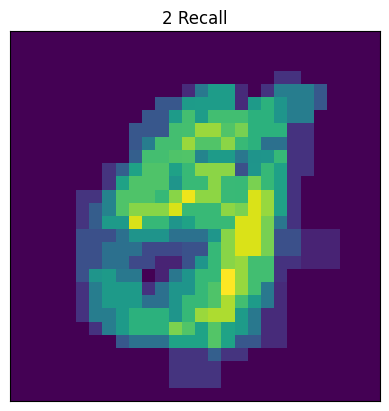

In [ ]:
nsteps = 2
final_query_state, (frames, energies) = min2.iterative_recall(
    masked_query, nsteps=nsteps
)
show_im(final_query_state, title=f"{nsteps} Recall")

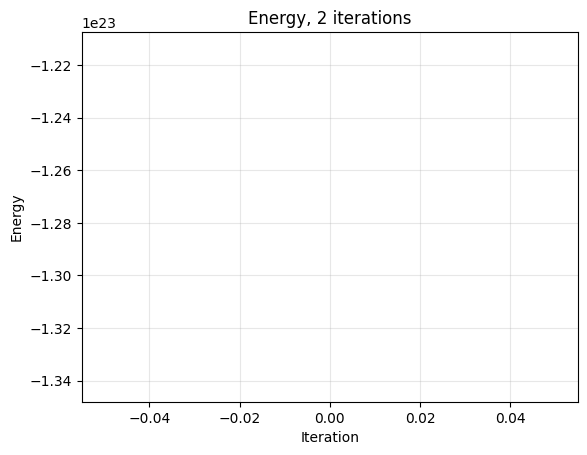

In [ ]:
plt.plot(energies)
plt.title(f"Energy, {nsteps} iterations")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.grid(True, alpha=0.3)
plt.show()

There is a decrease in energy, but the recalled trace is not at all close to our desired pattern (a handwritten $4$). If we do not
normalize the value at the end, however, then we get exploding values to $\infty$ or $\text{NaN}$ (undefined values), as we can see with the following:

In [ ]:
nsteps = 4
final_query_state, (frames, energies) = min2.iterative_recall(
    masked_query, nsteps=nsteps
)
final_query_state.max()

Array(nan, dtype=float32)

To solve this problem, we can introduce $\text{sgn}$ normalization into the iterated recall:

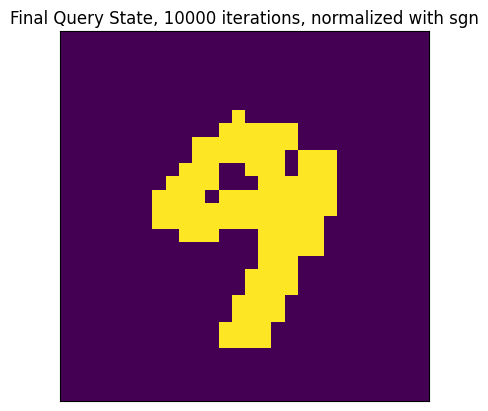

In [ ]:
nsteps = 10_000
final_query_state, (frames, energies) = min2.iterative_recall(
    masked_query, nsteps=nsteps, normalize_with_sgn=True,
)
show_im(final_query_state, f"Final Query State, {nsteps} iterations, normalized with sgn")

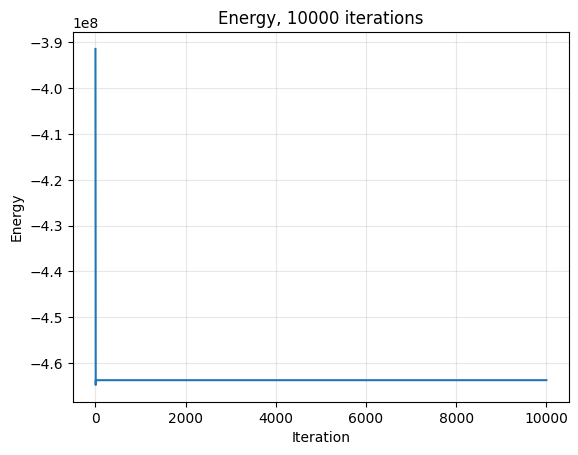

In [ ]:
plt.plot(energies)
plt.title(f"Energy, {nsteps} iterations")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.grid(True, alpha=0.3)
plt.show()

# Holographic Minerva

In [ ]:
# TODO: implement holographic minerva model

# Vector Intersector Units

In [ ]:
# TODO: implement vector intersector units

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()